# Importing Dependencies

In [55]:
import numpy as np
import cv2

import os
import tensorflow as tf

import matplotlib.pylab as plt

import tensorflow as tf
from keras.applications import ResNet50

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading Image Dateset

In [3]:
data_dir = 'imgdata_v3'

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256))

Found 2115 files belonging to 2 classes.


In [6]:
batch = dataset.as_numpy_iterator().next()
len(batch)

2

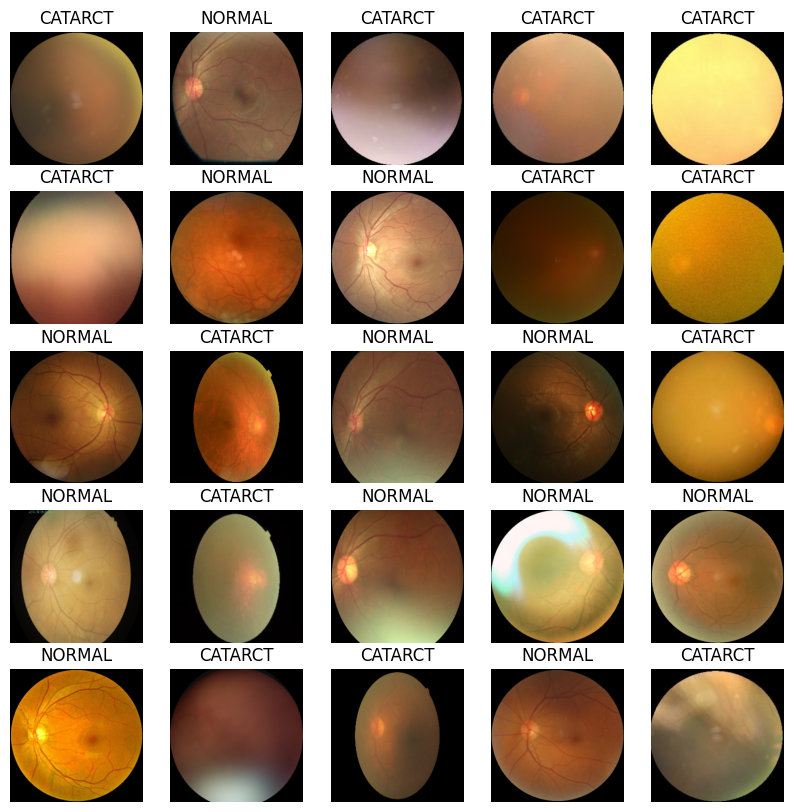

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for idx, img in enumerate(batch[0][:25]):
    row = idx//5
    col = idx%5
    
    axs[row, col].imshow(img.astype(int))
    axs[row, col].axis('off')
    axs[row, col].set_title('CATARCT' if batch[1][idx]==0 else 'NORMAL')

## Scaling Dataset

In [8]:
batch[0][0].shape, batch[0][0].max(), batch[0][0].min()

((256, 256, 3), 206.75, 0.0)

In [25]:
data = dataset.map(lambda x, y: (x/255, y))

In [26]:
print(data.as_numpy_iterator().next()[0][0].shape,
    data.as_numpy_iterator().next()[0][0].max(),
    data.as_numpy_iterator().next()[0][0].min())

(256, 256, 3) 0.9882353 0.0


# Splitting Dataset

In [27]:
len(data)

67

In [29]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+2
test_size = int(len(data)*0.1)

train_size + val_size + test_size

67

In [30]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

# ResneXT Model

In [48]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#Creating a copy
sequential_model = Model(inputs=base_model.input, outputs=base_model.output)

In [49]:
for i, layer in enumerate(sequential_model.layers):
    if isinstance(layer, Conv2D):
        filters = layer.filters
        group_filters = filters // 32
        new_layer = Conv2D(filters, kernel_size=layer.kernel_size, padding=layer.padding, groups=group_filters)
        sequential_model.layers[i] = new_layer

In [50]:
sequential_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [ ]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [47]:
sequential_model.fit(train_data, 
                     epochs=5,
                     shuffle=True, 
                     validation_data=val_data
                    # callbacks=[tfb_callback]
)

# Model Performance

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(sequential_model.history['loss'], color='red', label='Loss')
axs[0].plot(sequential_model.history['val_loss'], color='orange', label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(sequential_model.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(sequential_model.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

# Evaluating Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity

In [ ]:
pre = Precision()
acc = BinaryAccuracy()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

In [ ]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    spe.update_state(y, y_pred)

In [ ]:
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', acc.result().numpy())
print('Precision\t:', precision)
print('Recall\t\t:', recall)
print('Specificity\t:', spe.result().numpy())
print('F1\t\t:', f1)

# Exporting Model

In [ ]:
sequential_model.save(os.path.join('models', 'ODIR_ResNeXt.h5'))

In [ ]:
from tensorflow.keras.models import load_model

sequential_model = load_model(os.path.join('models', 'ODIR_VGG16.h5'))
sequential_model.summary()